In [1]:
from __future__ import division

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
from sklearn.decomposition import KernelPCA,IncrementalPCA,TruncatedSVD,MiniBatchSparsePCA
from sklearn.cluster import FeatureAgglomeration, MiniBatchKMeans, KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.feature_extraction import image
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from utils.prog import log_progress as lp
from matplotlib.patches import Rectangle
from sklearn.svm import SVC, LinearSVC
import statsmodels.formula.api as smf
from numpy import transpose as T
from IPython.display import HTML
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from utils import neuropsych
import scipy.stats as stats
from scipy import interp
import matplotlib as mpl
import sklearn.cluster
import nibabel as nib
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import palettable
import warnings
import scipy
import time
import json
import sys
import os

%matplotlib inline
%load_ext rpy2.ipython

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

CONDIR = os.environ.get("CONDIR")
CODEDIR = os.environ.get("CODEDIR")

#### Read in data

read in subject-wise connectomes, results, factorsolution

In [2]:
gsr = '' if True else '_gsr'
connectomes = np.load(os.path.join(CONDIR,'derivatives/connectomes%s.npy'%gsr))
results = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'),index_col=0)
factorsolution = pd.read_csv(os.path.join(os.environ.get("TABLEDIR"),"neuropsych_factor.csv"),index_col=0)

# check dimensions
assert(len(results)==connectomes.shape[2])

extract labels of Gordon atlas

In [3]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = [[x+333,x+10+333] for x in range(10)]
subprob = [x for sublist in subprob for x in sublist]
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*21+['cerebellum']*28
labels = np.unique(labelnames).tolist()
labelnames_unsorted = list(labeltable.Community)+['subcort']*21+['cerebellum']*28
ncon = len(labelnames)

#### Subset all connectomes/subjects that passed QC

In [4]:
# check which subjects pass QC
passubs = []
for idx,row in factorsolution.iterrows():
    ids = np.where(row.UID==results.subject)[0]
    qcs = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
    idqc = set(ids).intersection(qcs)
    if not len(idqc)==0:
        passubs.append(row.UID)

In [5]:
# combine QC'd results
ConClean = np.zeros([ncon,ncon,len(passubs)])
FacClean = pd.DataFrame({k:[] for k in factorsolution.columns})

for idx,sub in enumerate(passubs):
    ids = np.where(sub==results.subject)[0]
    qcs = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
    idqc = set(ids).intersection(qcs)
    con = np.mean(connectomes[:,:,np.array(list(idqc))],axis=2)
    con = con[:,order]
    con = con[order,:]
    ConClean[:,:,idx] = con
    FacRow = factorsolution.iloc[np.where(sub==factorsolution.UID)[0]]
    FacClean = FacClean.append(FacRow)

FacClean = FacClean.reset_index()

#### look at mean connectome

In [6]:
def gordon_figure(correlation,limits,labelnames,title,cmap="PuOr_r"):
    unique_labels = np.unique(labelnames)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for val,x in enumerate(labelnames)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(correlation,cmap = cmap,vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


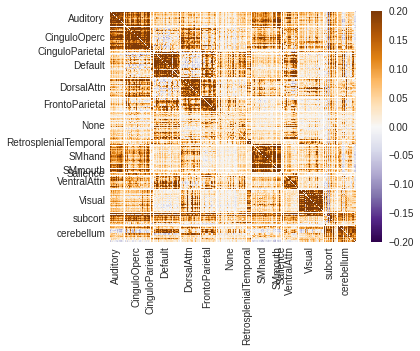

In [7]:
gordon_figure(np.mean(ConClean,axis=2),limits=[-0.2,0.2],labelnames=labelnames,title="")

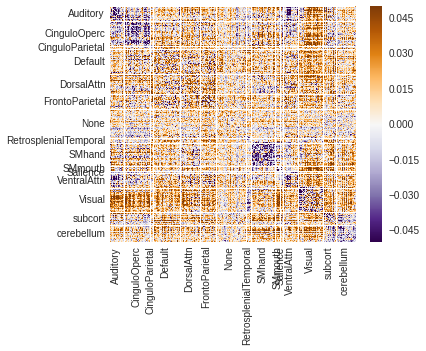

In [8]:
P = np.where(FacClean.patient=='patient')[0]
H = np.where(FacClean.patient=='HC')[0]
Pmn = ConClean[:,:,P]
Hmn = ConClean[:,:,H]
gordon_figure(np.mean(Pmn,axis=2)-np.mean(Hmn,axis=2),limits=[-0.05,0.05],labelnames=labelnames,title="")

## Select connectomes network-wise for data reduction

In [9]:
con_av = np.zeros([len(labels),len(labels),ConClean.shape[2]])

for idx1,label1 in enumerate(labels):
    for idx2,label2 in enumerate(labels):
        x1 = np.where(np.array(labelnames) == label1)[0]
        x2 = np.where(np.array(labelnames) == label2)[0]
        subsel = ConClean[x1,:,:]
        subsel = subsel[:,x2,:]
        if label1==label2:
            upid = np.triu_indices(len(x1))
            av = np.mean(subsel[upid],axis=0)
        else:
            av = np.mean(subsel,axis=(0,1))
        con_av[idx1,idx2,:] = av

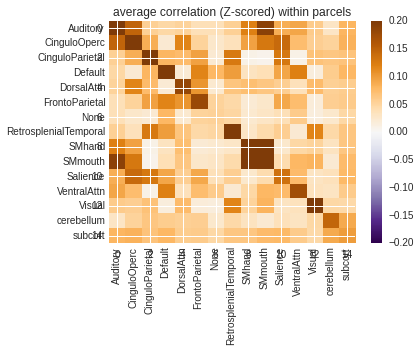

In [10]:
def cor_figure(cor,limits=[-0.2,0.2]):
    labels_num = np.arange(15)
    minor_ticks = np.arange(15)
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', 
                     edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(cor,cmap = "PuOr_r",vmin=limits[0],vmax=limits[1],aspect='auto',
                    interpolation='nearest')
    ax.set_title("average correlation (Z-scored) within parcels")
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(labels,minor=True,rotation=90)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(labels,minor=True)
    plt.colorbar(ax1)
    plt.tight_layout()

plt.plot()
cor_figure(np.mean(con_av,axis=2))

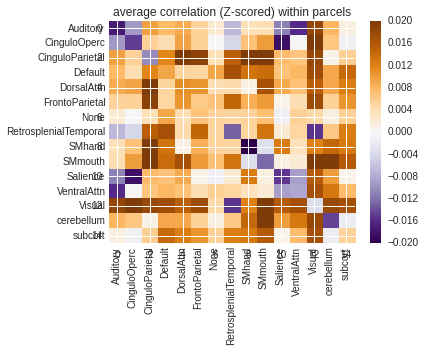

In [11]:
# look at mean difference to see if there's anything obvious to train
P = np.where(FacClean.patient=='patient')[0]
H = np.where(FacClean.patient=='HC')[0]
Pmn = con_av[:,:,P]
Hmn = con_av[:,:,H]
cor_figure(np.mean(Pmn,axis=2)-np.mean(Hmn,axis=2),limits=[-0.02,0.02])

## Check predictive ability of (summarised) correlation matrix

In [12]:
upid = np.triu_indices(15)
X_networks = np.transpose(con_av[upid])
Y_networks = np.array([1 if x=='patient' else 0 for x in FacClean.patient])

In [13]:
if True:
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_networks)
    X_networks = scaler.transform(X_networks)

### Look at distribution of connectome for each subject

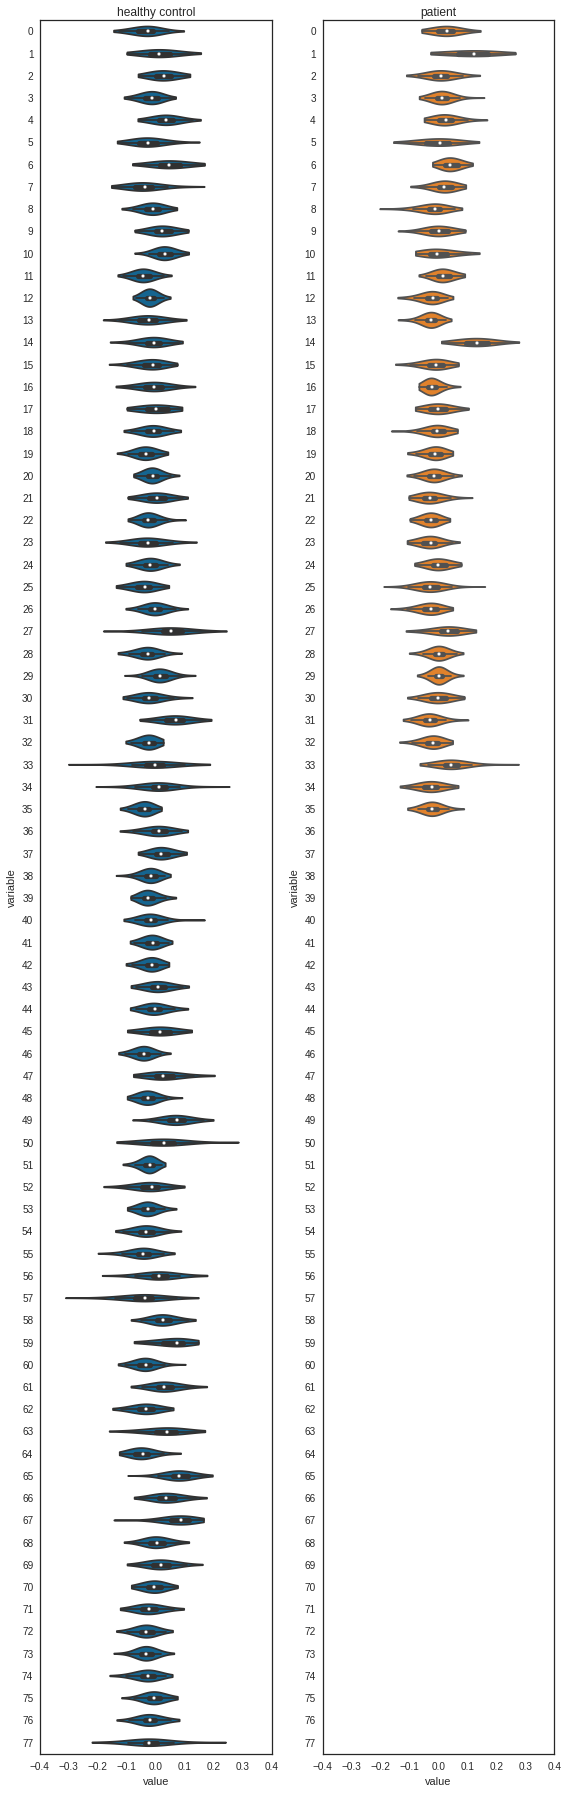

In [14]:
mpl.rcParams['grid.color'] = 'white'
sns.set_style('white')
f, axes = plt.subplots(1, 2, figsize=(8, 25), sharex=True)
for col in range(2):
    startr = [0,56][col]
    endr = [56,115][col]
    idx = np.where(Y_networks==col)[0]
    X_df = pd.DataFrame(np.transpose(X_networks[idx]))
    X_long = pd.melt(X_df,value_vars = range(78))
    sns.violinplot(x='value',y='variable',data=X_long,orient='h',bw=1,
                   title='distribution of continuous variables by patient',
                   ax=axes[col],cut=0,color=cols[col])
    axes[col].set_title('patient' if col==1 else 'healthy control')
    plt.tight_layout()

### Logistic regression

In [19]:
def compute_roc(X_init,Y_init,classifier,cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_init, Y_init):
        probas_ = classifier.fit(X_init[train], Y_init[train]).predict_proba(X_init[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_init[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1
    
    return mean_fpr,tprs,aucs

In [67]:
from sklearn.linear_model import LogisticRegression
# compute AUC
K = 10
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
classifier = LogisticRegression(dual=True,penalty="l2",solver='liblinear',C=0.8,class_weight='balanced')

mean_fpr,tprs,aucs = compute_roc(X_networks,Y_networks,classifier,cv)

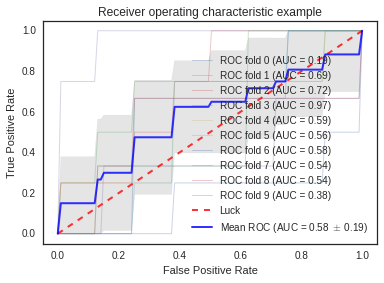

In [68]:
def roc_figure(mean_fpr,tprs,aucs):
    K = len(tprs)
    for k in range(K):
        plt.plot(mean_fpr,tprs[k],lw=1,alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (k, aucs[k]))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

roc_figure(mean_fpr,tprs,aucs)

Logistic regression seems to be working pretty good as seen on the ROC.  However, the predicted class is always `Healthy Control`, as any subject still has more chance to be HC than patient...  HOWEVER, this shows that this partitioning is pretty reasonable.

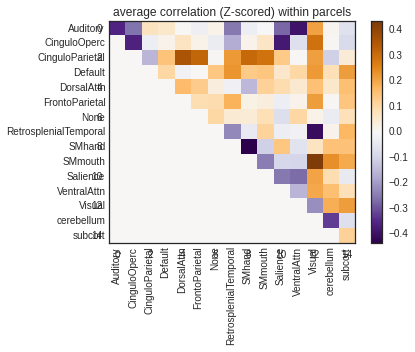

In [69]:
classifier.fit(X_networks,Y_networks)
new = np.zeros([15,15])
new[upid]=classifier.coef_[0,:]
lims = np.min([abs(min(new.flatten())),max(new.flatten())])
cor_figure(new,limits=[-lims,lims])

In [70]:
def plot_learning_curve(estimator,title,X,y,ylim,cv=None,n_jobs=3,
                        train_sizes = np.linspace(0.1,1.0,10)):
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training sample size")
    plt.ylabel("classification accuracy")
    plt.legend()
    
    return train_scores_mean, test_scores_mean

(array([ 0.825     ,  0.78125   ,  0.8       ,  0.775     ,  0.77      ,
         0.73333333,  0.74464286,  0.734375  ,  0.73333333,  0.7       ]),
 array([ 0.60022894,  0.59010989,  0.59844322,  0.6246337 ,  0.63237179,
         0.63415751,  0.62335165,  0.63218864,  0.60659341,  0.5893315 ]))

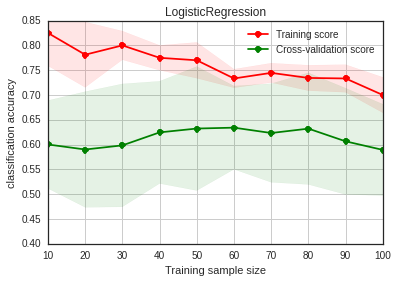

In [72]:
K = 8
cv = StratifiedKFold(n_splits=K)
sns.set_style("white")

plot_learning_curve(classifier,"LogisticRegression",
                    X_networks,Y_networks,ylim=[0.4,0.85],cv=cv)

The fact that the lines for the training and cross-validation are not together, indicates that there is not enough data to fit the model optimally; and the model is atm overfitting.

### Let's look at kernel methods: Support Vector Machines

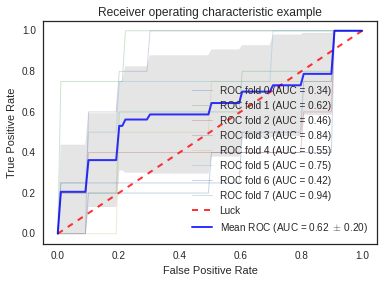

In [84]:
# compute AUC
K = 8
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
classifier = SVC(random_state=np.random.choice(2**32),probability=True,kernel='linear')

mean_fpr,tprs,aucs = compute_roc(X_networks,Y_networks,classifier,cv)

roc_figure(mean_fpr,tprs,aucs)

In [82]:
# classifier.fit(X_networks,Y_networks)
# new = np.zeros([15,15])
# new[upid]=classifier.coef_[0,:]
# lims = np.min([abs(min(new.flatten())),max(new.flatten())])
# cor_figure(new,limits=[-lims,lims])
classifier

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=1166763069, shrinking=True,
  tol=0.001, verbose=False)

(array([ 1.        ,  0.81875   ,  0.8125    ,  0.771875  ,  0.775     ,
         0.7625    ,  0.7875    ,  0.7546875 ,  0.70972222,  0.695     ]),
 array([ 0.65201465,  0.64308608,  0.61630037,  0.61630037,  0.6168956 ,
         0.61492674,  0.61492674,  0.5970696 ,  0.58099817,  0.57138278]))

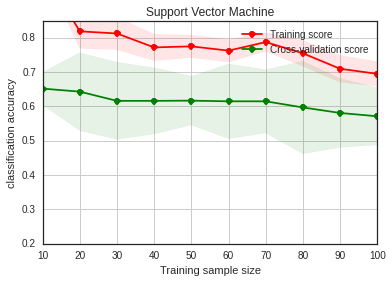

In [83]:
K = 8
cv = StratifiedKFold(n_splits=K)
sns.set_style("white")

plot_learning_curve(classifier,"Support Vector Machine",
                    X_networks,Y_networks,ylim=[0.2,0.85],cv=cv)

# How does it work on all data?

In [56]:
upid = np.triu_indices(ncon)
X_full = np.transpose(ConClean[upid])
if True:
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_full)
    X_full = scaler.transform(X_full)
Y_full = np.array([1 if x=='patient' else 0 for x in FacClean.patient])

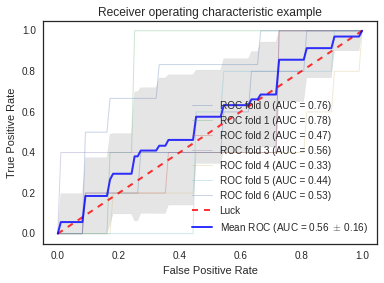

In [58]:
# compute AUC
K = 7
cv = StratifiedKFold(n_splits=K)
classifier = LogisticRegression(dual=True,penalty="l2",solver='liblinear',C=0.8)
#classifier = SVC(random_state=np.random.choice(2**32),probability=True,kernel='linear')

mean_fpr,tprs,aucs = compute_roc(X_full,Y_full,classifier,cv)
roc_figure(mean_fpr,tprs,aucs)

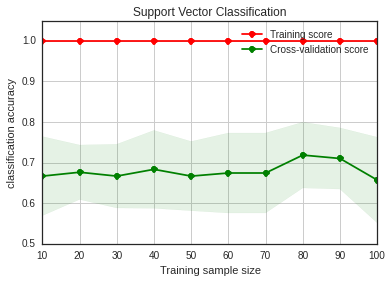

In [41]:
if True:
    cv = StratifiedKFold(n_splits=8)
    sns.set_style("white")

    estimator = LinearSVC()

    plot_learning_curve(estimator,"Support Vector Classification",
                        X_full,Y_full,ylim=[0.5,1.05],cv=cv)


That looks like a variance problem: overfitting on training dataset.

# How about a more data driven clustering?

In [46]:
def reduce_cormat(cormat,ncomp,algorithm):
    ncon = cormat.shape[0]
    nclusters = np.min([ncomp,ncon**2])
    upid = np.triu_indices(ncon)
    connectivity=image.grid_to_graph(n_x=ncon,n_y=ncon,mask=mask)
    corflat = cormat[upid]
    algorithm.n_components = ncomp
    algorithm.n_clusters = ncomp
    conred = np.transpose(algorithm.fit_transform(np.transpose(corflat)))
    return conred

In [119]:

mask = np.zeros([ncon,ncon])
upid = np.triu_indices(ncon)
mask[upid]=1
connectivity=image.grid_to_graph(n_x=ncon,n_y=ncon,mask=mask)
ward = FeatureAgglomeration(connectivity=connectivity,linkage='ward')

algs = {
    'GaussianMix':GaussianMixture(),
    "ward":ward,
    'kmeans':MiniBatchKMeans(),
    'pca':PCA(),
    'sigmoidPCA':KernelPCA(kernel='sigmoid'),
    'incrementalPCA':IncrementalPCA(),
    'fica':FastICA(),
    'SVD':TruncatedSVD(),
    'fa':FactorAnalysis(),
    'sparsepca':MiniBatchSparsePCA()
       }

#reduced = reduce_cormat(ConClean,100,algs['ward'])

In [50]:
numclus = np.arange(10,200,50)

clus_auc_mn = []; clus_auc_sd = []
out = {}

K = 5
cv = StratifiedKFold(n_splits=K,random_state=10000,shuffle=True)
classifier = SVC(random_state=6000,probability=True,kernel='linear')

for name,algorithm in algs.iteritems():
    clus_auc_mn = []; clus_auc_sd = []
    for nclus in lp(numclus):
        # ward clustering
        ConRed = reduce_cormat(ConClean,nclus,algorithm)
        X_red = np.transpose(ConRed)
        X_red = X_red-np.mean(X_red,axis=0)/np.std(X_red,axis=0)
        X_red = np.nan_to_num(X_red)
        mean_fpr,tprs,aucs = compute_roc(X_red,Y_full,classifier,cv)
        clus_auc_mn.append(np.mean(aucs))
        clus_auc_sd.append(np.std(aucs))
    out[name]=(clus_auc_mn,clus_auc_sd)

KeyboardInterrupt: 

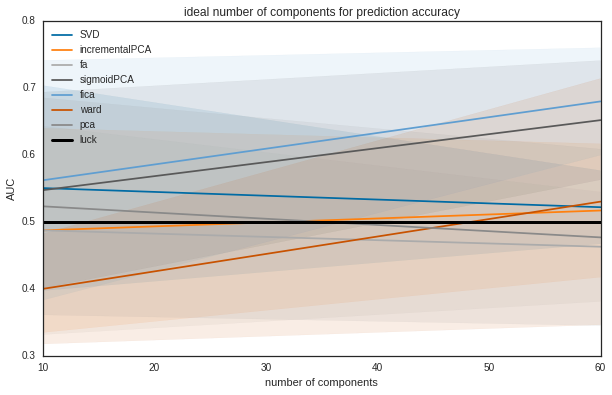

In [342]:
splits = 5
plt.figure(figsize=(10,6))
i=0
for k,v in out.iteritems():
    clus_auc_mn = v[0]
    clus_auc_sd = v[1]
    auc_upper_CI = np.array(clus_auc_mn) + 2*np.array(clus_auc_sd)/np.sqrt(splits)
    auc_lower_CI = np.array(clus_auc_mn) - 2*np.array(clus_auc_sd)/np.sqrt(splits)
    auc_upper_PI = np.array(clus_auc_mn) + 2*np.array(clus_auc_sd)
    auc_lower_PI = np.array(clus_auc_mn) - 2*np.array(clus_auc_sd)
    plt.fill_between(numclus, auc_lower_CI, auc_upper_CI, color=cols[i],alpha=0.1)
    plt.plot(numclus,clus_auc_mn,label=k,color=cols[i])
    i+=1

plt.plot(numclus,[0.5]*len(numclus),color='black',label='luck',lw=3)
plt.legend(loc='upper left')
plt.ylabel("AUC")
plt.xlabel("number of components")
plt.title("ideal number of components for prediction accuracy")

* Note that PCA has a maximum number of factors equal to the number of rows (now 115).

## Continue with one clustering algorithm

In [1]:
NCOM = 115

upid = np.triu_indices(ncon)
connectivity=image.grid_to_graph(n_x=ncon,n_y=ncon,mask=mask)
corflat = ConClean[upid]
model = PCA(n_components = NCOM,kernel='sigmoid')
model.fit(np.transpose(corflat))

NameError: name 'np' is not defined

In [108]:
ConRed = model.fit_transform(np.transpose(corflat))
ConRed.shape

(115, 100)

### Make figures of different components

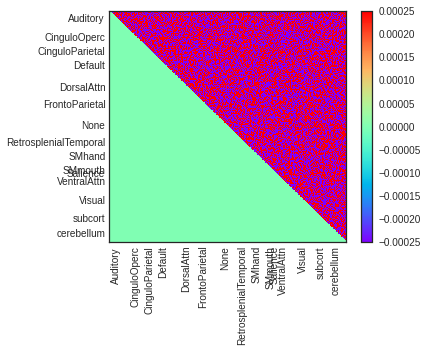

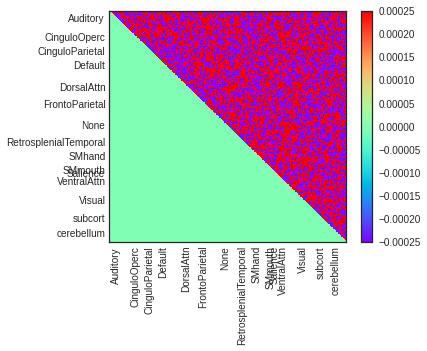

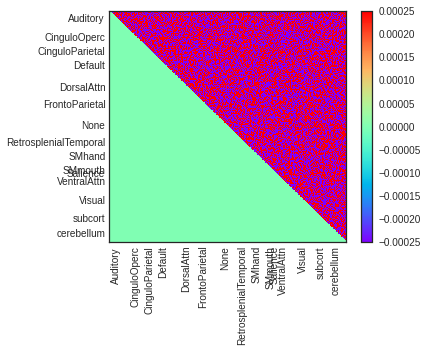

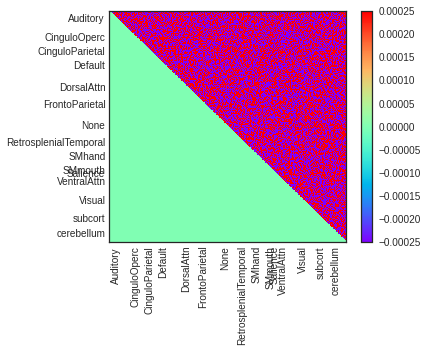

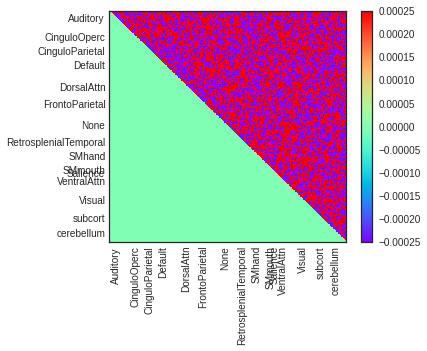

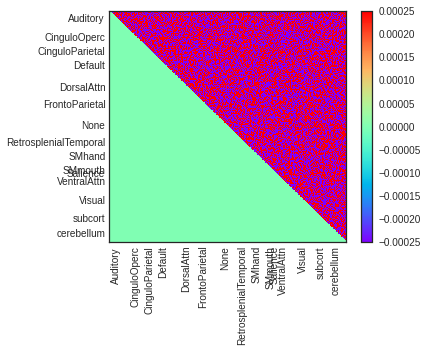

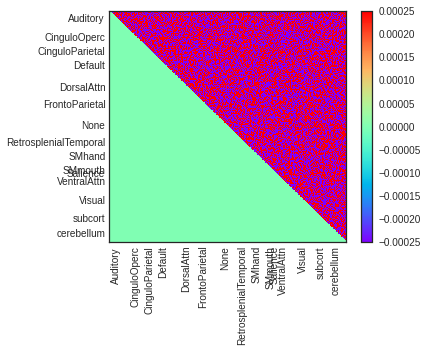

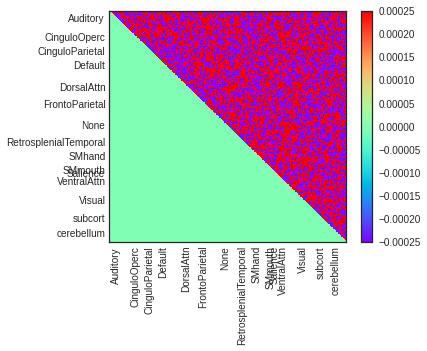

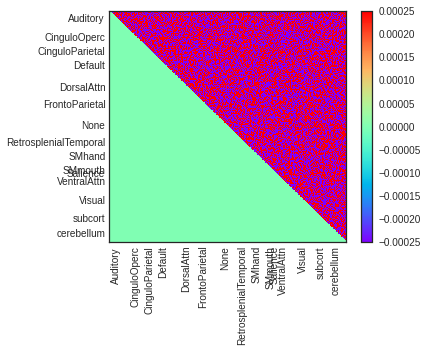

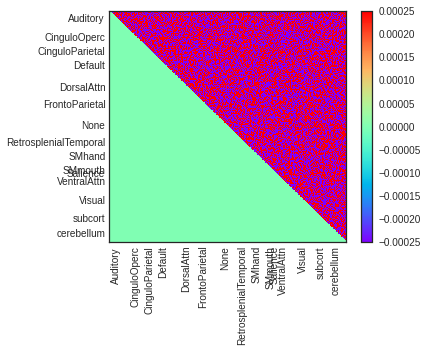

In [53]:
components = np.zeros([ncon,ncon,10])
for comp in range(10):
    ones = np.array([comp]*len(upid[0]))
    idx = (upid[0],upid[1],ones)
    components[idx] = model.components_[comp,:]
    gordon_figure(components[:,:,comp],limits=[-0.00025,0.00025],labelnames=labelnames,title="",cmap='rainbow')

### Predictive analysis

In [114]:
K = 8
cv = StratifiedKFold(n_splits=K)
classifier = SVC(random_state=4569302,probability=True,kernel='linear')

mean_fpr,tprs,aucs = compute_roc(ConRed,Y_full,classifier,cv)
roc_figure(mean_fpr,tprs,aucs)

AttributeError: 'KMeans' object has no attribute 'predict_proba'

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x2ae5ea766630, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/jdurne...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x2ae5ea766630, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/jdurne...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    398         
    399         if self.poller is not None:
    400             self.poller.start()
    401         self.kernel.start()
    402         try:
--> 403             ioloop.IOLoop.instance().start()
    404         except KeyboardInterrupt:
    405             pass
    406 
    407 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-10-30T13:19:42.466533', u'msg_id': u'2643B6D4F8934EFE8857113C151D5373', u'msg_type': u'execute_request', u'session': u'FE156EAEFB9A41D58586AD29A8E3A250', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2643B6D4F8934EFE8857113C151D5373', 'msg_type': u'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['FE156EAEFB9A41D58586AD29A8E3A250']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-10-30T13:19:42.466533', u'msg_id': u'2643B6D4F8934EFE8857113C151D5373', u'msg_type': u'execute_request', u'session': u'FE156EAEFB9A41D58586AD29A8E3A250', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2643B6D4F8934EFE8857113C151D5373', 'msg_type': u'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['FE156EAEFB9A41D58586AD29A8E3A250'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-10-30T13:19:42.466533', u'msg_id': u'2643B6D4F8934EFE8857113C151D5373', u'msg_type': u'execute_request', u'session': u'FE156EAEFB9A41D58586AD29A8E3A250', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'2643B6D4F8934EFE8857113C151D5373', 'msg_type': u'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'plot_learning_curve(classifier,"Support Vector...            ConRed,Y_full,ylim=[0.5,1.05],cv=cv)', store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-115-97dc651525f1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])
   3011                 code = compiler(mod, cell_name, "single")
-> 3012                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x2ae6a816ac30, file "<ipython-input-115-97dc651525f1>", line 1>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3013                     return True
   3014 
   3015             # Flush softspace
   3016             if softspace(sys.stdout, 0):

...........................................................................
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x2ae6a816ac30, file "<ipython-input-115-97dc651525f1>", line 1>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x2ae6a816ac30, file "<ipython-input-115-97dc651525f1>", line 1>
        self.user_global_ns = {'CODEDIR': '/home/jdurnez/Psychosis/', 'CONDIR': '/scratch/users/jdurnez/Psychosis_derivatives/connectivity_Joke/', 'ConClean': array([[[  0.00000000e+00,   0.00000000e+00,   0...00000e+00,   0.00000000e+00,   0.00000000e+00]]]), 'ConRed': array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), 'Counter': <class 'collections.Counter'>, 'FacClean':      index       UID  factor_0_(childhood_trauma...     0.339883  patient  

[115 rows x 13 columns], 'FacRow':      factor_0_(childhood_trauma)  factor_1_(psyc...     patient       UID  
153  patient  S3232XVO  , 'FactorAnalysis': <class 'sklearn.decomposition.factor_analysis.FactorAnalysis'>, 'FastICA': <class 'sklearn.decomposition.fastica_.FastICA'>, 'FeatureAgglomeration': <class 'sklearn.cluster.hierarchical.FeatureAgglomeration'>, ...}
        self.user_ns = {'CODEDIR': '/home/jdurnez/Psychosis/', 'CONDIR': '/scratch/users/jdurnez/Psychosis_derivatives/connectivity_Joke/', 'ConClean': array([[[  0.00000000e+00,   0.00000000e+00,   0...00000e+00,   0.00000000e+00,   0.00000000e+00]]]), 'ConRed': array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), 'Counter': <class 'collections.Counter'>, 'FacClean':      index       UID  factor_0_(childhood_trauma...     0.339883  patient  

[115 rows x 13 columns], 'FacRow':      factor_0_(childhood_trauma)  factor_1_(psyc...     patient       UID  
153  patient  S3232XVO  , 'FactorAnalysis': <class 'sklearn.decomposition.factor_analysis.FactorAnalysis'>, 'FastICA': <class 'sklearn.decomposition.fastica_.FastICA'>, 'FeatureAgglomeration': <class 'sklearn.cluster.hierarchical.FeatureAgglomeration'>, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
/home/jdurnez/Psychosis/06_predictive_model/<ipython-input-115-97dc651525f1> in <module>()
      1 
----> 2 
      3 
      4 
      5 plot_learning_curve(classifier,"Support Vector Classification",
      6                     ConRed,Y_full,ylim=[0.5,1.05],cv=cv)
      7 
      8 
      9 
     10 

...........................................................................
/home/jdurnez/Psychosis/06_predictive_model/<ipython-input-37-300ed40fdf69> in plot_learning_curve(estimator=KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), title='Support Vector Classification', X=array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), y=array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,... 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), ylim=[0.5, 1.05], cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False), n_jobs=3, train_sizes=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
      2                         train_sizes = np.linspace(0.1,1.0,10)):
      3     plt.figure()
      4     plt.title(title)
      5     plt.ylim(ylim)
      6     train_sizes, train_scores, test_scores = learning_curve(
----> 7         estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
      8     train_scores_mean = np.mean(train_scores, axis=1)
      9     train_scores_std = np.std(train_scores, axis=1)
     10     test_scores_mean = np.mean(test_scores, axis=1)
     11     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), X=array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), y=array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,... 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), groups=None, train_sizes=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False), scoring=None, exploit_incremental_learning=False, n_jobs=4, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([ 14,  15,  16,  18,  19,  20,  21,  22,  ...    106, 107, 108, 109, 110, 111, 112, 113, 114]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    106, 107, 108, 109, 110, 111, 112, 113, 114]), array([14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 31, 35])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    106, 107, 108, 109, 110, 111, 112, 113, 114]), array([26, 28, 30, 32, 33, 34, 36, 37, 38, 39, 40, 44, 46, 47, 48])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    106, 107, 108, 109, 110, 111, 112, 113, 114]), array([41, 42, 43, 45, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...05, 106, 107, 108, 109, 110, 111, 112, 113, 114]), array([59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...05, 106, 107, 108, 109, 110, 111, 112, 113, 114]), array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...05, 106, 107, 108, 109, 110, 111, 112, 113, 114]), array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...92,  93,  94,  95,  96,  97,  98,  99, 100, 102]), array([101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]))]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Oct 30 13:19:42 2017
PID: 22375      Python 2.7.13: /home/jdurnez/.conda/envs/my_root/bin/python
...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,... 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([14, 15, 16, 18, 19, 20, 21, 22, 23, 24]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
        self.items = [(<function _fit_and_score>, (KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,... 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), <function _passthrough_scorer>, array([14, 15, 16, 18, 19, 20, 21, 22, 23, 24]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), X=array([[ 39.42809472,  37.23130836,  43.25404999...3.83972674,
         35.18818083,  33.23844104]]), y=array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,... 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), scorer=<function _passthrough_scorer>, train=array([14, 15, 16, 18, 19, 20, 21, 22, 23, 24]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method KMeans.fit of KMeans(algorithm='au...',
    random_state=None, tol=0.0001, verbose=0)>
        X_train = array([[  3.72106261e+01,   3.56014995e+01,   3....01,   3.61095794e+01,
          3.40883173e+01]])
        y_train = array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cluster/k_means_.py in fit(self=KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), X=array([[  3.72106261e+01,   3.56014995e+01,   3....01,   3.61095794e+01,
          3.40883173e+01]]), y=array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
    875         ----------
    876         X : array-like or sparse matrix, shape=(n_samples, n_features)
    877             Training instances to cluster.
    878         """
    879         random_state = check_random_state(self.random_state)
--> 880         X = self._check_fit_data(X)
        X = array([[  3.72106261e+01,   3.56014995e+01,   3....01,   3.61095794e+01,
          3.40883173e+01]])
        self._check_fit_data = <bound method KMeans._check_fit_data of KMeans(a...',
    random_state=None, tol=0.0001, verbose=0)>
    881 
    882         self.cluster_centers_, self.labels_, self.inertia_, self.n_iter_ = \
    883             k_means(
    884                 X, n_clusters=self.n_clusters, init=self.init,

...........................................................................
/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cluster/k_means_.py in _check_fit_data(self=KMeans(algorithm='auto', copy_x=True, init='k-me...o',
    random_state=None, tol=0.0001, verbose=0), X=array([[  3.72106261e+01,   3.56014995e+01,   3....01,   3.61095794e+01,
          3.40883173e+01]]))
    852     def _check_fit_data(self, X):
    853         """Verify that the number of samples given is larger than k"""
    854         X = check_array(X, accept_sparse='csr', dtype=[np.float64, np.float32])
    855         if X.shape[0] < self.n_clusters:
    856             raise ValueError("n_samples=%d should be >= n_clusters=%d" % (
--> 857                 X.shape[0], self.n_clusters))
        X.shape = (10, 100)
        self.n_clusters = 100
    858         return X
    859 
    860     def _check_test_data(self, X):
    861         X = check_array(X, accept_sparse='csr', dtype=FLOAT_DTYPES)

ValueError: n_samples=10 should be >= n_clusters=100
___________________________________________________________________________

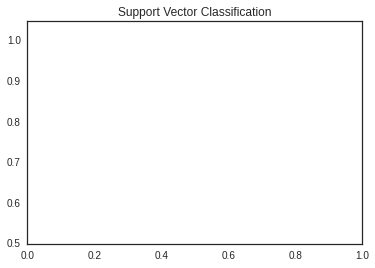

In [115]:
plot_learning_curve(classifier,"Support Vector Classification",
                    ConRed,Y_full,ylim=[0.5,1.05],cv=cv)

In [96]:
new = np.zeros([ncon,ncon])
new[upid] = model.inverse_transform(ConRed[0,:])

AttributeError: 'MiniBatchKMeans' object has no attribute 'inverse_transform'

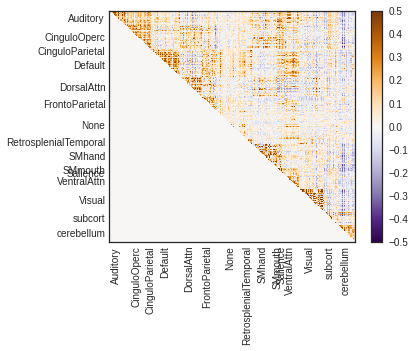

In [87]:
gordon_figure(new,limits=[-0.5,0.5],labelnames=labelnames,title="")

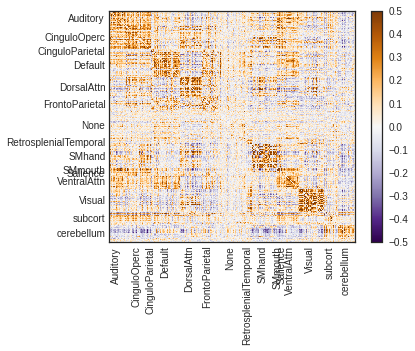

In [89]:
gordon_figure(ConClean[:,:,0],limits=[-0.5,0.5],labelnames=labelnames,title="")

Standardise columns

### Split train-dev

In [ ]:
facols = [x for x in FacClean.columns if x.startswith("factor")]
X = np.array(FacClean[facols])
print("shape of factor solution: %s"%str(X.shape))

In [ ]:
Y = np.transpose(np.array(ConRed))
print("shape of factor solution: %s"%str(Y.shape))

In [ ]:
pool = range(X.shape[0])
tsi = list(np.random.choice(pool,int(0.2*X.shape[0]),replace=False))
tni = list(set(pool)-set(tsi))

In [ ]:
X_train = X[tni,:]
X_test = X[tsi,:]
Y_train = Y[tni,:]
Y_test = Y[tsi,:]

### Apply CCA

In [ ]:
assert(len(tsi)+len(tni)==int(X.shape[0]))
print("There are %i subjects in the training set"%(len(tni)))

In [ ]:
from sklearn.cross_decomposition import PLSCanonical
cca = PLSCanonical(n_components = 8)
cca.fit(X_train,Y_train)
X_transf,Y_transf = cca.transform(X_train,Y_train)

In [ ]:
covar = np.transpose(cca.y_weights_).dot(cca.y_weights_)
plt.imshow(covar,interpolation='nearest')

In [ ]:
cca.y_weights_.shape

In [ ]:
# canonische variabele 1
ncor = connectomes.shape[0]
canvar = np.zeros([ncor,ncor,8])
for cvar in range(8):
    canvar1 = cca.y_weights_[:,cvar]
    # terug naar unieke correlaties
    canvar1_recomp = pcafit.inverse_transform(canvar1)
    # terug naar correlatiematrix
    recon = np.zeros([ncon,ncon])
    recon[upid] = canvar1_recomp
    canvar[:,:,cvar] = recon
    gordon_figure(recon,limits=[0,0.001],labelnames=labelnames,title="")

In [ ]:
stats.pearsonr(canvar[:,:,0].flatten(),canvar[:,:,1].flatten())

In [ ]:
np.random.normal(0,1,115)

In [ ]:
# this code makes nice figures of factors and their loadings

labels = ['childhood_trauma','psychosis','legal','family_mental_health','mood_depression','family_psychosis',
                'IQ_(-)','family_psychiatry','substance','?']

minor_ticks = np.arange(len(labels))

fig = plt.figure(figsize=(5, 8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(cca.x_weights_,
                aspect='auto',interpolation='nearest',cmap='coolwarm')
ax.set_yticks(np.arange(len(labels)),minor=True)
ax.set_yticklabels(labels,minor=True)
ax.set_xlabel("canonical variables")
plt.colorbar(ax1)
plt.tight_layout()


In [ ]:
X_transf,Y_transf = cca.transform(X_test,Y_test)
X_transf.shape
for x in range(10):
    print(stats.pearsonr(X_transf[:,x],Y_transf[:,x]))

In [ ]:
cca.get_params()
print(cca.y_weights_[0])
print(cca.y_loadings_[0])